In [397]:
# Install libraries the first time
# ! pip install -q ipynb yfinance pandas pathlib numpy

In [398]:
from fastai.tabular.all import *
import yfinance as yf
import pandas as pd
import pathlib
from datetime import *
import numpy as np
import matplotlib.pyplot as plt
import random

### Variables

In [426]:
modelName = 'stockScreenerV1.0'
trainingData = 'stockData.csv'
getNewData = True 
trainNewModel = True
predictionTarget = None # 'ALL' for all tickers decending, 'None' for no prediction

# Training parameters
trainingSize = 400 # Number of stocks to get from the test tickers
timeFrame = 'max'  # Options: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
yNames = ['Future Year Change']
catNames = ['Industry']
contNames = [
    'Open',
    'Close', 
    'Volume', 
    'Dividends', 
    'Stock Splits', 
    'EV/EBIT', 
    'ROIC'
]
epochs = 10

# Test parameters
testSize = 500 # Number of stocks to test. 'ALL' for all non-training stocks

# Folder- and file paths
dataFolder = Path.cwd().parent / 'TrainingData'
dataName = 'stockData.csv'
testFolder = Path.cwd().parent / 'TestData'
trainingFolder = Path.cwd().parent / 'TrainingData'
modelFolder = Path.cwd().parent.parent / 'TrainedModels'
testFolder = Path.cwd().parent / 'TestData'

### Ticker cleaning (remove duplicates)

In [400]:
# Load the data from the CSV file
df = pd.read_csv(testFolder / 'tickers.csv')
    
# Remove duplicate rows
df = df.drop_duplicates().reset_index(drop=True)
    
# Save the cleaned data to a new file
df.to_csv(testFolder / 'tickers.csv', index=False)

### Functions for Data Collection and Processing

In [401]:
def get_industry(ticker_symbol):
    try:
        return yf.Ticker(ticker_symbol).info.get('industry', 'Unknown')
    except Exception as e:
        print(f"Error fetching industry for {ticker_symbol}: {e}")
        return 'Error'

In [402]:
def calculate_future_year_change(ticker_symbol, timeframe, buffer=1):
    valid_periods = ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']
    try:
        if timeframe == 'max':
            future_change = yf.Ticker(ticker_symbol).history(period='max')
            future_change['Future Year Change'] = (future_change['Close'].shift(-252) / future_change['Close'] - 1)
            future_change = future_change.dropna(subset=['Future Year Change'])
        else:
            extended_timeframe = valid_periods[valid_periods.index(timeframe) + buffer]
            future_change = yf.Ticker(ticker_symbol).history(period=extended_timeframe)
            future_change['Future Year Change'] = (future_change['Close'].shift(-252) / future_change['Close'] - 1)

            end_date = future_change.index[-1] - pd.DateOffset(years=1)
            start_date = end_date - pd.DateOffset(years=int(timeframe[:-1]))
            future_change = future_change.loc[start_date:end_date].dropna(subset=['Future Year Change'])
        return future_change
    except Exception as e:
        print(f"Error processing {ticker_symbol}: {e}")
        return pd.DataFrame()

In [403]:
def get_static_ev_data(ticker_symbol):
    try:
        info = yf.Ticker(ticker_symbol).info
        return info.get('totalDebt', 0), info.get('totalCash', 0), info.get('sharesOutstanding', None)
    except Exception as e:
        print(f"Error fetching EV components for {ticker_symbol}: {e}")
        return None, None, None

In [404]:
def calculate_approx_ebit(ticker_symbol):
    try:
        info = yf.Ticker(ticker_symbol).info
        revenue = info.get('totalRevenue', None)
        operating_income = info.get('operatingIncome', None)
        return operating_income if operating_income else (revenue * 0.15 if revenue else None)
    except Exception as e:
        print(f"Error calculating EBIT for {ticker_symbol}: {e}")
        return None

In [405]:
def calculate_daily_ev_ebit(hist_data):
    hist_data['EV/EBIT'] = None
    for symbol in hist_data['Ticker'].unique():
        ticker_data = hist_data[hist_data['Ticker'] == symbol].copy()
        total_debt, cash, shares_outstanding = get_static_ev_data(symbol)
        ebit = calculate_approx_ebit(symbol)

        if shares_outstanding and ebit and ebit != 0:
            ticker_data['EV'] = (ticker_data['Close'] * shares_outstanding) + total_debt - cash
            ticker_data['EV/EBIT'] = ticker_data['EV'] / ebit
            hist_data.loc[ticker_data.index, 'EV/EBIT'] = ticker_data['EV/EBIT']
    return hist_data.drop(columns=['EV'], errors='ignore')

In [406]:
def calculate_daily_roic(hist_data):
    for symbol in hist_data['Ticker'].unique():
        ticker_data = hist_data[hist_data['Ticker'] == symbol].copy()
        total_debt, cash, shares_outstanding = get_static_ev_data(symbol)
        ebit = calculate_approx_ebit(symbol)

        if shares_outstanding and ebit:
            tax_rate = 0.21
            nopat = ebit * (1 - tax_rate)
            invested_capital = total_debt + (ticker_data['Close'] * shares_outstanding) - cash
            ticker_data['ROIC'] = np.where(invested_capital != 0, nopat / invested_capital, None)
            hist_data.loc[ticker_data.index, 'ROIC'] = ticker_data['ROIC']
    return hist_data

In [407]:
def getTickerData(ticker_symbol):
    try:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period='1d')
        total_debt, cash, shares_outstanding = get_static_ev_data(ticker_symbol)
        ebit = calculate_approx_ebit(ticker_symbol)
        ev = (hist['Close'].iloc[-1] * shares_outstanding) + total_debt - cash
        ev_ebit = ev / ebit if ebit else None
        market_cap = hist['Close'].iloc[-1] * shares_outstanding
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = get_industry(ticker_symbol)

        return pd.DataFrame([{
            'Open': hist['Open'].iloc[-1],
            'High': hist['High'].iloc[-1],
            'Low': hist['Low'].iloc[-1],
            'Close': hist['Close'].iloc[-1],
            'Volume': hist['Volume'].iloc[-1],
            'Dividends': hist.get('Dividends', pd.Series([0.0])).iloc[-1],
            'Stock Splits': hist.get('Stock Splits', pd.Series([0.0])).iloc[-1],
            'EV/EBIT': ev_ebit,
            'Market Cap': market_cap,
            'ROIC': roic,
            'Industry': industry
        }])
    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return pd.DataFrame()

In [408]:
def getTickerDataFrom1YrAgo(ticker_symbol):
    try:
        # Fetch ticker data
        ticker = yf.Ticker(ticker_symbol)

        # Define the date range: one year ago to today
        today = datetime.today()
        one_year_ago = today - timedelta(days=365)

        # Fetch historical data for one year ago
        hist = ticker.history(start=(one_year_ago - timedelta(days=30)).strftime('%Y-%m-%d'), 
                              end=(one_year_ago + timedelta(days=0)).strftime('%Y-%m-%d'))
        if hist.empty:
            raise ValueError(f"No historical data available for {ticker_symbol} around {one_year_ago.strftime('%Y-%m-%d')}.")

        # Extract the closest data point to one year ago
        row = hist.iloc[0]  # Get the first available entry within the date range

        # Price today
        price_today = ticker.history(period='1d')['Close'].iloc[-1]

        # Calculate future price change (from one year ago to today)
        price_change_future = ((price_today - row['Close']) / row['Close']) if row['Close'] else None

        # Collect additional data
        total_debt, cash, shares_outstanding = get_static_ev_data(ticker_symbol)
        ebit = calculate_approx_ebit(ticker_symbol)
        ev = (row['Close'] * shares_outstanding) + total_debt - cash if shares_outstanding else None
        ev_ebit = ev / ebit if ebit else None
        market_cap = row['Close'] * shares_outstanding if shares_outstanding else None
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash if market_cap and total_debt and cash else None
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = get_industry(ticker_symbol)

        # Return as a DataFrame
        return pd.DataFrame([{
            'Date': row.name,
            'Open': row['Open'],
            'High': row['High'],
            'Low': row['Low'],
            'Close': row['Close'],
            'Volume': row['Volume'],
            'Dividends': row.get('Dividends', 0.0),
            'Stock Splits': row.get('Stock Splits', 0.0),
            'Future Year Change': price_change_future,
            'Industry': industry,
            'EV/EBIT': ev_ebit,
            'ROIC': roic
        }])

    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return pd.DataFrame()


In [409]:
if getNewData == True:
    hist_data = pd.DataFrame()
    symbols = pd.read_csv(testFolder / 'tickers.csv')['Ticker']
    trainingTickers = np.random.choice(symbols, size=trainingSize, replace=False).tolist()
    for trainingTicker in trainingTickers:
        try:
            future_change = calculate_future_year_change(trainingTicker, timeFrame)
            future_change['Ticker'] = trainingTicker
            future_change['Industry'] = get_industry(trainingTicker)
            hist_data = pd.concat([hist_data, future_change])
        except Exception as e:
            print(f"Error processing {trainingTicker}: {e}")

    hist_data.reset_index(inplace=True)
    hist_data = calculate_daily_ev_ebit(hist_data)
    hist_data = calculate_daily_roic(hist_data)
    hist_data.to_csv(dataFolder / trainingData, index=False)

trainingRows = pd.read_csv(dataFolder / trainingData)
print(len(trainingRows))

$TRIT: possibly delisted; no timezone found
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TRIT?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TRIT&crumb=vSmwn1lwQ8s
C:\Users\Gamer\AppData\Local\Temp\ipykernel_14704\3605072956.py:10: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  hist_data = pd.concat([hist_data, future_change])
$NRF: possibly delisted; no price data found  (1d 1926-02-15 -> 2025-01-21)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_14704\3605072956.py:10: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining th

Error fetching EV components for JPI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/JPI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=JPI&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for JPI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TCPC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TCPC&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for TCPC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TCPC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TCPC&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for TCPC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TMS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TMS&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for TMS: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TMS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TMS&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for TMS: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/KMI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=KMI&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for KMI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/KMI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=KMI&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for KMI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NIE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NIE&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for NIE: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NIE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NIE&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for NIE: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/OB?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=OB&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for OB: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/OB?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=OB&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for OB: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HTLD?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HTLD&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for HTLD: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HTLD?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HTLD&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for HTLD: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RH?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RH&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for RH: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RH?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RH&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for RH: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/QUAD?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=QUAD&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for QUAD: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/QUAD?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=QUAD&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for QUAD: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/LMT?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=LMT&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for LMT: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/LMT?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=LMT&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for LMT: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GIL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GIL&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for GIL: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GIL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GIL&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for GIL: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MNDO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MNDO&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for MNDO: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MNDO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MNDO&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for MNDO: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MKTX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MKTX&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for MKTX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MKTX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MKTX&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for MKTX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SPBC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SPBC&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for SPBC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SPBC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SPBC&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for SPBC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MAC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MAC&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for MAC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MAC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MAC&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for MAC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GSL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GSL&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for GSL: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GSL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GSL&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for GSL: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SGMO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SGMO&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for SGMO: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SGMO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SGMO&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for SGMO: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DORM?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DORM&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for DORM: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DORM?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DORM&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for DORM: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DAIO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DAIO&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for DAIO: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DAIO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DAIO&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for DAIO: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SOFO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SOFO&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for SOFO: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SOFO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SOFO&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for SOFO: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NPO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NPO&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for NPO: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NPO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NPO&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for NPO: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MGYR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MGYR&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for MGYR: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MGYR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MGYR&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for MGYR: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DHX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DHX&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for DHX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DHX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DHX&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for DHX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ROIC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ROIC&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for ROIC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ROIC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ROIC&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for ROIC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FENG?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FENG&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for FENG: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FENG?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FENG&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for FENG: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ROMA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ROMA&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for ROMA: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ROMA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ROMA&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for ROMA: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/WEN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=WEN&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for WEN: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/WEN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=WEN&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for WEN: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ISSC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ISSC&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for ISSC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ISSC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ISSC&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for ISSC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TDC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TDC&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for TDC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TDC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TDC&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for TDC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CNK?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CNK&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for CNK: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CNK?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CNK&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for CNK: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FUL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FUL&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for FUL: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FUL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FUL&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for FUL: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RGLS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RGLS&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for RGLS: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RGLS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RGLS&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for RGLS: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/OPOF?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=OPOF&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for OPOF: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/OPOF?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=OPOF&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for OPOF: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HPI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HPI&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for HPI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HPI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HPI&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for HPI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TRN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TRN&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for TRN: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TRN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TRN&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for TRN: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/WVFC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=WVFC&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for WVFC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/WVFC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=WVFC&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for WVFC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EXEL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EXEL&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for EXEL: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EXEL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EXEL&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for EXEL: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CSQ?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CSQ&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for CSQ: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CSQ?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CSQ&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for CSQ: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ARWR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ARWR&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for ARWR: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ARWR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ARWR&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for ARWR: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RMBS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RMBS&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for RMBS: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RMBS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RMBS&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for RMBS: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FLEX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FLEX&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for FLEX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FLEX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FLEX&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for FLEX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TRNS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TRNS&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for TRNS: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TRNS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TRNS&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for TRNS: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SMRT?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SMRT&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for SMRT: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SMRT?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SMRT&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for SMRT: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/JNY?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=JNY&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for JNY: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/JNY?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=JNY&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for JNY: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/OMEX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=OMEX&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for OMEX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/OMEX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=OMEX&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for OMEX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/L?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=L&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for L: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/L?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=L&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for L: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/JBI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=JBI&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for JBI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/JBI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=JBI&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for JBI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/LMNR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=LMNR&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for LMNR: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/LMNR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=LMNR&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for LMNR: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CCOI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CCOI&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for CCOI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CCOI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CCOI&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for CCOI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NKE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NKE&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for NKE: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NKE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NKE&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for NKE: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EGAN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EGAN&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for EGAN: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EGAN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EGAN&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for EGAN: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CX&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for CX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CX&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for CX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MPV?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MPV&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for MPV: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MPV?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MPV&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for MPV: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EVN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EVN&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for EVN: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EVN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EVN&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for EVN: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HEI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HEI&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for HEI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HEI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HEI&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for HEI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TWI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TWI&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for TWI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TWI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TWI&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for TWI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EHTH?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EHTH&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for EHTH: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EHTH?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EHTH&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for EHTH: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BGS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BGS&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for BGS: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BGS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BGS&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for BGS: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AWI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AWI&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for AWI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AWI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AWI&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for AWI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CHH?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CHH&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for CHH: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CHH?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CHH&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for CHH: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RNST?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RNST&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for RNST: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RNST?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RNST&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for RNST: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TJX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TJX&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for TJX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TJX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TJX&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for TJX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SYY?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SYY&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for SYY: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SYY?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SYY&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for SYY: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MCBK?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MCBK&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for MCBK: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MCBK?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MCBK&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for MCBK: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BSPM?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BSPM&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for BSPM: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BSPM?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BSPM&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for BSPM: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FOSL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FOSL&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for FOSL: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FOSL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FOSL&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for FOSL: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DGRE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DGRE&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for DGRE: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DGRE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DGRE&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for DGRE: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/JBL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=JBL&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for JBL: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/JBL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=JBL&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for JBL: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GLW?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GLW&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for GLW: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GLW?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GLW&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for GLW: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AXP?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AXP&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for AXP: Expecting value: line 1 column 1 (char 0)


401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AXP?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AXP&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for AXP: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GIL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GIL&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for GIL: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GIL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GIL&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for GIL: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MNDO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MNDO&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for MNDO: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MNDO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MNDO&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for MNDO: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MKTX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MKTX&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for MKTX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MKTX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MKTX&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for MKTX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SPBC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SPBC&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for SPBC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SPBC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SPBC&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for SPBC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MAC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MAC&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for MAC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MAC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MAC&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for MAC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GSL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GSL&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for GSL: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GSL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GSL&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for GSL: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SGMO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SGMO&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for SGMO: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SGMO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SGMO&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for SGMO: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DORM?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DORM&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for DORM: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DORM?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DORM&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for DORM: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DAIO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DAIO&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for DAIO: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DAIO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DAIO&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for DAIO: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SOFO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SOFO&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for SOFO: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SOFO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SOFO&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for SOFO: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NPO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NPO&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for NPO: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NPO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NPO&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for NPO: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MGYR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MGYR&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for MGYR: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MGYR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MGYR&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for MGYR: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DHX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DHX&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for DHX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DHX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DHX&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for DHX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ROIC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ROIC&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for ROIC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ROIC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ROIC&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for ROIC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FENG?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FENG&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for FENG: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FENG?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FENG&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for FENG: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ROMA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ROMA&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for ROMA: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ROMA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ROMA&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for ROMA: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/WEN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=WEN&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for WEN: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/WEN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=WEN&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for WEN: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ISSC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ISSC&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for ISSC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ISSC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ISSC&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for ISSC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TDC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TDC&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for TDC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TDC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TDC&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for TDC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CNK?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CNK&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for CNK: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CNK?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CNK&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for CNK: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FUL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FUL&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for FUL: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FUL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FUL&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for FUL: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RGLS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RGLS&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for RGLS: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RGLS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RGLS&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for RGLS: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/OPOF?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=OPOF&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for OPOF: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/OPOF?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=OPOF&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for OPOF: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HPI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HPI&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for HPI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HPI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HPI&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for HPI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TRN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TRN&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for TRN: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TRN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TRN&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for TRN: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/WVFC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=WVFC&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for WVFC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/WVFC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=WVFC&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for WVFC: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EXEL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EXEL&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for EXEL: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EXEL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EXEL&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for EXEL: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CSQ?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CSQ&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for CSQ: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CSQ?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CSQ&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for CSQ: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ARWR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ARWR&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for ARWR: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ARWR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ARWR&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for ARWR: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RMBS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RMBS&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for RMBS: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RMBS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RMBS&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for RMBS: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FLEX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FLEX&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for FLEX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FLEX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FLEX&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for FLEX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TRNS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TRNS&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for TRNS: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TRNS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TRNS&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for TRNS: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SMRT?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SMRT&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for SMRT: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SMRT?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SMRT&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for SMRT: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/JNY?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=JNY&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for JNY: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/JNY?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=JNY&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for JNY: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/OMEX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=OMEX&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for OMEX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/OMEX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=OMEX&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for OMEX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/L?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=L&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for L: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/L?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=L&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for L: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/JBI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=JBI&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for JBI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/JBI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=JBI&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for JBI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/LMNR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=LMNR&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for LMNR: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/LMNR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=LMNR&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for LMNR: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CCOI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CCOI&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for CCOI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CCOI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CCOI&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for CCOI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NKE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NKE&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for NKE: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NKE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NKE&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for NKE: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EGAN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EGAN&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for EGAN: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EGAN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EGAN&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for EGAN: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CX&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for CX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CX&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for CX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MPV?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MPV&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for MPV: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MPV?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MPV&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for MPV: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EVN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EVN&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for EVN: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EVN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EVN&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for EVN: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HEI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HEI&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for HEI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HEI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HEI&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for HEI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TWI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TWI&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for TWI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TWI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TWI&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for TWI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EHTH?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EHTH&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for EHTH: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EHTH?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EHTH&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for EHTH: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BGS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BGS&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for BGS: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BGS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BGS&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for BGS: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AWI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AWI&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for AWI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AWI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AWI&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for AWI: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CHH?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CHH&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for CHH: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CHH?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CHH&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for CHH: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RNST?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RNST&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for RNST: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RNST?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RNST&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for RNST: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TJX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TJX&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for TJX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TJX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TJX&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for TJX: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SYY?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SYY&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for SYY: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SYY?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SYY&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for SYY: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MCBK?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MCBK&crumb=Edge%3A+Too+Many+Requests


Error fetching EV components for MCBK: Expecting value: line 1 column 1 (char 0)


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MCBK?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MCBK&crumb=Edge%3A+Too+Many+Requests


Error calculating EBIT for MCBK: Expecting value: line 1 column 1 (char 0)
1220547


Then we can have a look at how the data is structured:

In [410]:
dataPath = Path()
df = pd.read_csv(trainingFolder/trainingData)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Future Year Change,Ticker,Industry,Adj Close,Capital Gains,EV/EBIT,ROIC
0,2008-12-18 00:00:00-05:00,36.750072,57.750114,36.750072,36.750072,28.0,0.0,0.0,1.114286,BSPM,Drug Manufacturers - Specialty & Generic,NaN,NaN,2076.377541,NaN
1,2008-12-19 00:00:00-05:00,36.750072,36.750072,36.750072,36.750072,0.0,0.0,0.0,1.102857,BSPM,Drug Manufacturers - Specialty & Generic,NaN,NaN,2076.377541,NaN
2,2008-12-22 00:00:00-05:00,36.750072,36.750072,36.750072,36.750072,0.0,0.0,0.0,1.142857,BSPM,Drug Manufacturers - Specialty & Generic,NaN,NaN,2076.377541,NaN
3,2008-12-23 00:00:00-05:00,36.750072,36.750072,36.750072,36.750072,0.0,0.0,0.0,1.137143,BSPM,Drug Manufacturers - Specialty & Generic,NaN,NaN,2076.377541,NaN
4,2008-12-24 00:00:00-05:00,36.750072,36.750072,36.750072,36.750072,0.0,0.0,0.0,1.137143,BSPM,Drug Manufacturers - Specialty & Generic,NaN,NaN,2076.377541,NaN


Some of the columns are continuous (like age) and we will treat them as float numbers we can feed our model directly. Others are categorical (like workclass or education) and we will convert them to a unique index that we will feed to embedding layers. We can specify our categorical and continuous column names, as well as the name of the dependent variable in TabularDataLoaders factory methods:

In [411]:
dls = TabularDataLoaders.from_csv(trainingFolder / trainingData, path=dataPath, 
    y_names=yNames,
    cat_names=catNames,
    cont_names=contNames,
    procs = [Categorify, FillMissing, Normalize])

c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

The last part is the list of pre-processors we apply to our data:

* Categorify is going to take every categorical variable and make a map from integer to unique categories, then replace the values by the corresponding index.
* FillMissing will fill the missing values in the continuous variables by the median of existing values (you can choose a specific value if you prefer)
* Normalize will normalize the continuous variables (subtract the mean and divide by the std)

To further expose what’s going on below the surface, let’s rewrite this utilizing fastai’s TabularPandas class. We will need to make one adjustment, which is defining how we want to split our data. By default the factory method above used a random 80/20 split, so we will do the same:

In [412]:
splits = EndSplitter (valid_pct=0.2, valid_last=True)(range_of(df))

In [413]:
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
    y_names=yNames,
    cat_names = catNames,
    cont_names = contNames,
    splits=splits)

c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

Once we build our TabularPandas object, our data is completely preprocessed as seen below:

In [414]:
to.xs.iloc[:1]

,Industry,EV/EBIT_na,ROIC_na,Open,Close,Volume,Dividends,Stock Splits,EV/EBIT,ROIC
0,21,1,2,-0.08622,-0.086384,-0.308885,-0.003224,-0.013295,0.187666,-0.000339


Now we can build our DataLoaders again:

In [415]:
dls = to.dataloaders(bs=64)

The show_batch method works like for every other application:

In [416]:
dls.show_batch()

,Industry,EV/EBIT_na,ROIC_na,Open,Close,Volume,Dividends,Stock Splits,EV/EBIT,ROIC,Future Year Change
0,Specialty Industrial Machinery,False,False,8.310503,8.388094,1.101302e+06,-1.749650e-10,-4.255991e-12,3.088536,0.255786,-0.068473
1,Oil & Gas Equipment & Services,False,False,1156.186875,1170.999879,4.900799e+04,-1.749650e-10,-4.255991e-12,315.275273,0.002506,0.131855
2,Asset Management,False,False,4.529217,4.689101,5.450003e+04,-1.749650e-10,-4.255991e-12,281.571748,0.002806,-0.297609
3,Diagnostics & Research,False,False,13.899978,14.100020,1.283000e+05,-1.749650e-10,-4.255991e-12,7.639616,0.103408,0.001418
4,Electronic Components,False,True,0.631390,0.631380,5.599996e+04,-1.749650e-10,-4.255991e-12,0.335132,0.082064,1.067309
5,Asset Management,False,False,3.130317,3.138816,6.367000e+05,-1.749650e-10,-4.255991e-12,113.610962,0.006954,-0.017560
6,Banks - Regional,False,False,15.013768,14.957507,1.539998e+04,-1.749650e-10,-4.255991e-12,17.017427,0.046423,-0.004345
7,Biotechnology,True,True,5.929987,6.140000,6.805000e+05,-1.749650e-10,-4.255991e-12,7.603861,0.082064,-0.283388
8,Oil & Gas Midstream,True,False,15.964041,15.935696,1.281550e+07,-1.749650e-10,-4.255991e-12,7.603861,0.026601,0.550606
9,Specialty Chemicals,False,False,113.942764,114.419655,9.256000e+05,-1.749650e-10,-4.255991e-12,16.160709,0.048884,0.109445


We can define a model using the tabular_learner method. When we define our model, fastai will try to infer the loss function based on our y_names earlier.

Note: Sometimes with tabular data, your y’s may be encoded (such as 0 and 1). In such a case you should explicitly pass y_block = CategoryBlock in your constructor so fastai won’t presume you are doing regression.

And we can train that model with the fit_one_cycle method (the fine_tune method won’t be useful here since we don’t have a pretrained model).

We can then have a look at some training predictions:

In [417]:
if trainNewModel == True:
    learn = tabular_learner(dls, metrics=[rmse, mae])

    print(f"Training {modelName} for {epochs} epochs")
    learn.fit_one_cycle(epochs)

    learn.show_results(max_n=15)

    learn.export(modelFolder / f'{modelName}.pkl')

Training stockScreenerV1.0 for 10 epochs


epoch,train_loss,valid_loss,_rmse,mae,time
0,92.935745,0.912276,0.955131,0.539645,02:16
1,49.987530,292150.093750,540.509583,9.139553,02:17
2,58.963360,194589.359375,441.123596,7.703465,02:17
3,9.079184,18.528034,4.304425,0.672403,02:23
4,3.903880,1130.199829,33.618546,1.004101,02:17
5,138.505585,13.005715,3.606342,1.143633,02:20
6,80.326973,3.204184,1.790022,1.172562,02:18
7,83.959869,2.781713,1.667848,1.065019,02:19
8,48.655811,116.134377,10.776569,1.058172,02:17
9,21.216095,4.856212,2.203683,0.986476,02:35


,Industry,EV/EBIT_na,ROIC_na,Open,Close,Volume,Dividends,Stock Splits,EV/EBIT,ROIC,Future Year Change,Future Year Change_pred
0,6.0,2.0,2.0,-0.092261,-0.092422,-0.297045,-0.003224,-0.013295,-0.018178,-0.000339,-0.075786,0.333734
1,43.0,2.0,2.0,-0.085645,-0.085737,-0.287231,-0.003224,-0.013295,-0.018178,-0.000339,0.180267,2.256815
2,72.0,2.0,2.0,-0.088948,-0.089085,-0.119774,-0.003224,-0.013295,-0.018178,-0.000339,0.126140,1.593444
3,68.0,2.0,2.0,-0.091346,-0.091522,-0.280011,-0.003224,-0.013295,-0.018178,-0.000339,-0.054098,1.021399
4,72.0,2.0,2.0,-0.091986,-0.092123,-0.239377,-0.003224,-0.013295,-0.018178,-0.000339,0.376909,1.710291
5,6.0,2.0,2.0,-0.092273,-0.092432,-0.285590,-0.003224,-0.013295,-0.018178,-0.000339,-0.259025,0.332324
6,6.0,2.0,2.0,-0.092631,-0.092796,-0.207802,-0.003224,-0.013295,-0.018178,-0.000339,-0.072497,0.335966
7,31.0,2.0,2.0,-0.092282,-0.092462,3.219593,-0.003224,-0.013295,-0.018178,-0.000339,0.381219,-0.214317
8,24.0,2.0,2.0,-0.091766,-0.091958,2.687320,-0.003224,-0.013295,-0.018178,-0.000339,-0.715517,-0.290569
9,43.0,2.0,2.0,-0.091952,-0.092151,-0.245416,-0.003224,-0.013295,-0.018178,-0.000339,0.078249,1.966886


## Evaluation

In [421]:
def evaluate_model(learn, testTickers, model_name, model_folder, cont_names, cat_names):
    """
    Evaluate a fastai model on a list of test tickers and log the results.
    
    Args:
        learn: fastai Learner object
        testTickers (list): List of ticker symbols to test on
        model_name (str): Name of the model for logging
        model_folder (Path): Path to save evaluation results
        cont_names (list): List of continuous feature names
        cat_names (list): List of categorical feature names
    """
    all_predictions = []
    all_actuals = []
    test_data_list = []
    
    # Collect test data for all tickers
    for ticker in testTickers:
        try:
            # Get test data
            test_data = getTickerDataFrom1YrAgo(ticker)
            if test_data.empty:
                print(f"Skipping {ticker} due to missing data")
                continue
            
            test_data_list.append(test_data)
            
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            continue
    
    if not test_data_list:
        print("No valid test data collected")
        return None, None, None
    
    # Combine all test data
    combined_test_data = pd.concat(test_data_list, ignore_index=True)
    
    # Create fastai test dataloader
    test_dl = learn.dls.test_dl(combined_test_data)
    
    # Get predictions
    preds, targs = learn.get_preds(dl=test_dl)
    
    # Convert to numpy arrays
    predictions = preds.numpy()
    actuals = targs.numpy()
    
    # Create DataFrame for analysis
    results_df = pd.DataFrame({
        'Predicted': predictions.flatten(),
        'Actual': actuals.flatten()
    })

    # Calculate residuals
    results_df['Residual'] = results_df['Actual'] - results_df['Predicted']

    # Define outlier threshold (2 standard deviations)
    outlier_threshold = 2 * results_df['Residual'].std()

    # Filter outliers
    filtered_df = results_df[abs(results_df['Residual']) <= outlier_threshold]

    # Calculate metrics
    mae = np.mean(np.abs(filtered_df['Residual']))
    rmse = np.sqrt(np.mean(filtered_df['Residual']**2))
    r2 = 1 - (np.sum(filtered_df['Residual']**2) / 
              np.sum((filtered_df['Actual'] - filtered_df['Actual'].mean())**2))

    # Log results
    log_evaluation(model_name, mae, rmse, r2, model_folder, testTickers)
    
    # Create visualizations
    plot_results(filtered_df, model_name, model_folder)
    
    return mae, rmse, r2

def log_evaluation(model_name, mae, rmse, r2, model_folder, testTickers):
    """Log evaluation metrics to CSV file"""
    log_file = model_folder / "modelEvaluations.csv"
    
    new_entry_df = pd.DataFrame([{
        "Model Name": modelName,
        "Timestamp": datetime.now().strftime('%Y-%m-%d %H:%M'),
        "MAE": f'{mae:.3f}',
        "RMSE": f'{rmse:.3f}',
        "R2": f'{r2:.3f}',
        "Epochs": epochs,
        "Training Size": trainingSize,
        "Test Size": len(testTickers),
        "Cat Names": catNames,
        "Cont Names": contNames,
    }])
    
    try:
        log_df = pd.read_csv(log_file)
        log_df = pd.concat([log_df, new_entry_df], ignore_index=True)
    except FileNotFoundError:
        log_df = new_entry_df
        
    log_df.to_csv(log_file, index=False)
    print(f"Logged evaluation results to {log_file}")

def plot_results(filtered_df, model_name, model_folder):
    """Create and save visualization plots"""
    plt.figure(figsize=(12, 8))
    
    # Scatter plot
    plt.subplot(2, 1, 1)
    actuals = filtered_df['Actual']
    predictions = filtered_df['Predicted']
    plt.scatter(actuals, predictions, alpha=0.7, label='Predictions')
    
    # Perfect prediction line
    min_val = min(actuals.min(), predictions.min())
    max_val = max(actuals.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], 
             color='red', linestyle='--', label='Perfect Prediction')
    
    plt.title(f'Predicted vs. Actual Returns - {model_name}', fontsize=14)
    plt.xlabel('Actual Returns', fontsize=12)
    plt.ylabel('Predicted Returns', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.5)
    
    # Residual plot
    plt.subplot(2, 1, 2)
    plt.scatter(predictions, filtered_df['Residual'], alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot', fontsize=14)
    plt.xlabel('Predicted Returns', fontsize=12)
    plt.ylabel('Residual', fontsize=12)
    plt.grid(alpha=0.5)
    
    plt.tight_layout()
    
    # Show plot
    plt.show()

Amount of test tickers: 500, Expected: 500
['WAYN', 'NAFC', 'NXQ', 'APAGF', 'SNI', 'AWF', 'DOVR', 'TIF', 'ICCC', 'NCT-B', 'JASO', 'NI', 'SBNY', 'MAG', 'GAB-G', 'HRL', 'PXLW', 'WRLD', 'HAS', 'PHI', 'ACT', 'NCI', 'LSE-C', 'GS-I', 'AEIS', 'NNI', 'AYR', 'NE', 'RNA', 'HTBK', 'COWN', 'BIS', 'FULLL', 'HMST', 'NGPC', 'UVSP', 'SUPX', 'AIRT', 'EVT', 'MTG', 'WSTC', 'ORA', 'THTI', 'DMB', 'PBT', 'BDMS', 'KEP', 'ETR', 'EXG', 'NID', 'CVC', 'GTI', 'NUM', 'NMA', 'USAP', 'AGEN', 'CNX', 'PER', 'PPP', 'BEE-C', 'YHOO', 'ESC', 'NAD', 'ROC', 'NRF-D', 'ACTG', 'LSTR', 'BEBE', 'BRK.B', 'LXP', 'PZC', 'FRF', 'SKT', 'DRAD', 'JHI', 'WAFDW', 'UBS', 'CBB-B', 'CMK', 'RCMT', 'EAGLU', 'FMY', 'PSCE', 'TPH', 'TROVW', 'SWZ', 'GLP', 'BIB', 'AGCO', 'BUSE', 'PTGI', 'SMM', 'ESBK', 'DARA', 'LOGM', 'DW', 'PVTBP', 'GOODO', 'DCTH', 'EPL', 'WSCI', 'YUME', 'SATS', 'CYNI', 'ANR', 'JBLU', 'HTBX', 'AHL-PC', 'LEAP', 'MEAS', 'FNV', 'NVSL', 'SSW-D', 'FID', 'MDLZ', 'AIR', 'STCK', 'KOG', 'LOR', 'LBAI', 'LNKD', 'HNRG', 'NXJ-A', 'JEC', 'E', '

$WAYN: possibly delisted; no timezone found
$NAFC: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for WAYN: No historical data available for WAYN around 2024-01-22.
Skipping WAYN due to missing data
Error fetching data for NAFC: No historical data available for NAFC around 2024-01-22.
Skipping NAFC due to missing data


$NXQ: possibly delisted; no timezone found
$APAGF: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for NXQ: No historical data available for NXQ around 2024-01-22.
Skipping NXQ due to missing data
Error fetching data for APAGF: No historical data available for APAGF around 2024-01-22.
Skipping APAGF due to missing data


$SNI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for SNI: No historical data available for SNI around 2024-01-22.
Skipping SNI due to missing data


$DOVR: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for DOVR: No historical data available for DOVR around 2024-01-22.
Skipping DOVR due to missing data


$TIF: possibly delisted; no timezone found


Error fetching data for TIF: No historical data available for TIF around 2024-01-22.
Skipping TIF due to missing data


$NCT-B: possibly delisted; no timezone found


Error fetching data for NCT-B: No historical data available for NCT-B around 2024-01-22.
Skipping NCT-B due to missing data


$JASO: possibly delisted; no timezone found


Error fetching data for JASO: No historical data available for JASO around 2024-01-22.
Skipping JASO due to missing data


$SBNY: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22) (Yahoo error = "Data doesn't exist for startDate = 1703307600, endDate = 1705899600")


Error fetching data for SBNY: No historical data available for SBNY around 2024-01-22.
Skipping SBNY due to missing data


$GAB-G: possibly delisted; no timezone found


Error fetching data for GAB-G: No historical data available for GAB-G around 2024-01-22.
Skipping GAB-G due to missing data


$NCI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22) (Yahoo error = "Data doesn't exist for startDate = 1703307600, endDate = 1705899600")


Error fetching data for NCI: No historical data available for NCI around 2024-01-22.
Skipping NCI due to missing data


$LSE-C: possibly delisted; no timezone found


Error fetching data for LSE-C: No historical data available for LSE-C around 2024-01-22.
Skipping LSE-C due to missing data


$GS-I: possibly delisted; no timezone found


Error fetching data for GS-I: No historical data available for GS-I around 2024-01-22.
Skipping GS-I due to missing data


$AYR: possibly delisted; no timezone found


Error fetching data for AYR: No historical data available for AYR around 2024-01-22.
Skipping AYR due to missing data


$COWN: possibly delisted; no timezone found


Error fetching data for COWN: No historical data available for COWN around 2024-01-22.
Skipping COWN due to missing data


$FULLL: possibly delisted; no timezone found


Error fetching data for FULLL: No historical data available for FULLL around 2024-01-22.
Skipping FULLL due to missing data


$NGPC: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for NGPC: No historical data available for NGPC around 2024-01-22.
Skipping NGPC due to missing data


$SUPX: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for SUPX: No historical data available for SUPX around 2024-01-22.
Skipping SUPX due to missing data


$WSTC: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for WSTC: No historical data available for WSTC around 2024-01-22.
Skipping WSTC due to missing data


$THTI: possibly delisted; no timezone found


Error fetching data for THTI: No historical data available for THTI around 2024-01-22.
Skipping THTI due to missing data


$BDMS: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for BDMS: No historical data available for BDMS around 2024-01-22.
Skipping BDMS due to missing data


$NID: possibly delisted; no timezone found
$CVC: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for NID: No historical data available for NID around 2024-01-22.
Skipping NID due to missing data
Error fetching data for CVC: No historical data available for CVC around 2024-01-22.
Skipping CVC due to missing data


$NUM: possibly delisted; no timezone found


Error fetching data for NUM: No historical data available for NUM around 2024-01-22.
Skipping NUM due to missing data


$NMA: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for NMA: No historical data available for NMA around 2024-01-22.
Skipping NMA due to missing data


$PER: possibly delisted; no timezone found
$PPP: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for PER: No historical data available for PER around 2024-01-22.
Skipping PER due to missing data
Error fetching data for PPP: No historical data available for PPP around 2024-01-22.
Skipping PPP due to missing data


$BEE-C: possibly delisted; no timezone found


Error fetching data for BEE-C: No historical data available for BEE-C around 2024-01-22.
Skipping BEE-C due to missing data


$YHOO: possibly delisted; no timezone found
$ESC: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for YHOO: No historical data available for YHOO around 2024-01-22.
Skipping YHOO due to missing data
Error fetching data for ESC: No historical data available for ESC around 2024-01-22.
Skipping ESC due to missing data


$ROC: possibly delisted; no timezone found


Error fetching data for ROC: No historical data available for ROC around 2024-01-22.
Skipping ROC due to missing data


$NRF-D: possibly delisted; no timezone found


Error fetching data for NRF-D: No historical data available for NRF-D around 2024-01-22.
Skipping NRF-D due to missing data


$BEBE: possibly delisted; no price data found  (period=1d)


Error fetching data for BEBE: single positional indexer is out-of-bounds
Skipping BEBE due to missing data


$BRK.B: possibly delisted; no timezone found


Error fetching data for BRK.B: No historical data available for BRK.B around 2024-01-22.
Skipping BRK.B due to missing data


$FRF: possibly delisted; no timezone found


Error fetching data for FRF: No historical data available for FRF around 2024-01-22.
Skipping FRF due to missing data


$DRAD: possibly delisted; no timezone found


Error fetching data for DRAD: No historical data available for DRAD around 2024-01-22.
Skipping DRAD due to missing data


$WAFDW: possibly delisted; no timezone found


Error fetching data for WAFDW: No historical data available for WAFDW around 2024-01-22.
Skipping WAFDW due to missing data


$CBB-B: possibly delisted; no timezone found
$CMK: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for CBB-B: No historical data available for CBB-B around 2024-01-22.
Skipping CBB-B due to missing data
Error fetching data for CMK: No historical data available for CMK around 2024-01-22.
Skipping CMK due to missing data


$EAGLU: possibly delisted; no timezone found


Error fetching data for EAGLU: No historical data available for EAGLU around 2024-01-22.
Skipping EAGLU due to missing data


$TROVW: possibly delisted; no timezone found


Error fetching data for TROVW: No historical data available for TROVW around 2024-01-22.
Skipping TROVW due to missing data


$PTGI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for PTGI: No historical data available for PTGI around 2024-01-22.
Skipping PTGI due to missing data


$SMM: possibly delisted; no timezone found


Error fetching data for SMM: No historical data available for SMM around 2024-01-22.
Skipping SMM due to missing data


$ESBK: possibly delisted; no timezone found
$DARA: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for ESBK: No historical data available for ESBK around 2024-01-22.
Skipping ESBK due to missing data
Error fetching data for DARA: No historical data available for DARA around 2024-01-22.
Skipping DARA due to missing data


$LOGM: possibly delisted; no timezone found


Error fetching data for LOGM: No historical data available for LOGM around 2024-01-22.
Skipping LOGM due to missing data


$DW: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for DW: No historical data available for DW around 2024-01-22.
Skipping DW due to missing data


$PVTBP: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for PVTBP: No historical data available for PVTBP around 2024-01-22.
Skipping PVTBP due to missing data


$EPL: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for EPL: No historical data available for EPL around 2024-01-22.
Skipping EPL due to missing data


$WSCI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$YUME: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for WSCI: No historical data available for WSCI around 2024-01-22.
Skipping WSCI due to missing data
Error fetching data for YUME: No historical data available for YUME around 2024-01-22.
Skipping YUME due to missing data


$CYNI: possibly delisted; no timezone found
$ANR: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for CYNI: No historical data available for CYNI around 2024-01-22.
Skipping CYNI due to missing data
Error fetching data for ANR: No historical data available for ANR around 2024-01-22.
Skipping ANR due to missing data


$HTBX: possibly delisted; no timezone found


Error fetching data for HTBX: No historical data available for HTBX around 2024-01-22.
Skipping HTBX due to missing data


$AHL-PC: possibly delisted; no price data found  (period=1d)


Error fetching data for AHL-PC: single positional indexer is out-of-bounds
Skipping AHL-PC due to missing data


$LEAP: possibly delisted; no timezone found
$MEAS: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for LEAP: No historical data available for LEAP around 2024-01-22.
Skipping LEAP due to missing data
Error fetching data for MEAS: No historical data available for MEAS around 2024-01-22.
Skipping MEAS due to missing data


$NVSL: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for NVSL: No historical data available for NVSL around 2024-01-22.
Skipping NVSL due to missing data


$SSW-D: possibly delisted; no timezone found


Error fetching data for SSW-D: No historical data available for SSW-D around 2024-01-22.
Skipping SSW-D due to missing data


$STCK: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for STCK: No historical data available for STCK around 2024-01-22.
Skipping STCK due to missing data


$KOG: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for KOG: No historical data available for KOG around 2024-01-22.
Skipping KOG due to missing data


$LOR: possibly delisted; no timezone found


Error fetching data for LOR: No historical data available for LOR around 2024-01-22.
Skipping LOR due to missing data


$LBAI: possibly delisted; no price data found  (period=1d)
$LNKD: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for LBAI: single positional indexer is out-of-bounds
Skipping LBAI due to missing data
Error fetching data for LNKD: No historical data available for LNKD around 2024-01-22.
Skipping LNKD due to missing data


$NXJ-A: possibly delisted; no timezone found


Error fetching data for NXJ-A: No historical data available for NXJ-A around 2024-01-22.
Skipping NXJ-A due to missing data


$JEC: possibly delisted; no timezone found


Error fetching data for JEC: No historical data available for JEC around 2024-01-22.
Skipping JEC due to missing data


$MODN: possibly delisted; no timezone found
$SCL.P: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for MODN: No historical data available for MODN around 2024-01-22.
Skipping MODN due to missing data
Error fetching data for SCL.P: No historical data available for SCL.P around 2024-01-22.
Skipping SCL.P due to missing data


$WBKC: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for WBKC: No historical data available for WBKC around 2024-01-22.
Skipping WBKC due to missing data


$COOL: possibly delisted; no timezone found


Error fetching data for COOL: No historical data available for COOL around 2024-01-22.
Skipping COOL due to missing data


$LRAD: possibly delisted; no timezone found


Error fetching data for LRAD: No historical data available for LRAD around 2024-01-22.
Skipping LRAD due to missing data


$JPM-I: possibly delisted; no timezone found


Error fetching data for JPM-I: No historical data available for JPM-I around 2024-01-22.
Skipping JPM-I due to missing data


$PEB-B: possibly delisted; no timezone found


Error fetching data for PEB-B: No historical data available for PEB-B around 2024-01-22.
Skipping PEB-B due to missing data


$RTI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for RTI: No historical data available for RTI around 2024-01-22.
Skipping RTI due to missing data


$BCF: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for BCF: No historical data available for BCF around 2024-01-22.
Skipping BCF due to missing data


$ERA: possibly delisted; no timezone found


Error fetching data for ERA: No historical data available for ERA around 2024-01-22.
Skipping ERA due to missing data


$BGG: possibly delisted; no timezone found


Error fetching data for BGG: No historical data available for BGG around 2024-01-22.
Skipping BGG due to missing data


$UBP-F: possibly delisted; no timezone found
$LVLT: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for UBP-F: No historical data available for UBP-F around 2024-01-22.
Skipping UBP-F due to missing data
Error fetching data for LVLT: No historical data available for LVLT around 2024-01-22.
Skipping LVLT due to missing data


$VVTV: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$NQ: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for VVTV: No historical data available for VVTV around 2024-01-22.
Skipping VVTV due to missing data
Error fetching data for NQ: No historical data available for NQ around 2024-01-22.
Skipping NQ due to missing data


$CKEC: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for CKEC: No historical data available for CKEC around 2024-01-22.
Skipping CKEC due to missing data


$JPM-A: possibly delisted; no timezone found


Error fetching data for JPM-A: No historical data available for JPM-A around 2024-01-22.
Skipping JPM-A due to missing data


$PWRD: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for PWRD: No historical data available for PWRD around 2024-01-22.
Skipping PWRD due to missing data


$BOBE: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for BOBE: No historical data available for BOBE around 2024-01-22.
Skipping BOBE due to missing data


$GMLP: possibly delisted; no timezone found
$FSYS: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for GMLP: No historical data available for GMLP around 2024-01-22.
Skipping GMLP due to missing data
Error fetching data for FSYS: No historical data available for FSYS around 2024-01-22.
Skipping FSYS due to missing data


$ECTY: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for ECTY: No historical data available for ECTY around 2024-01-22.
Skipping ECTY due to missing data


$LSBI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for LSBI: No historical data available for LSBI around 2024-01-22.
Skipping LSBI due to missing data


$OZRK: possibly delisted; no timezone found


Error fetching data for OZRK: No historical data available for OZRK around 2024-01-22.
Skipping OZRK due to missing data


$GS-A: possibly delisted; no timezone found


Error fetching data for GS-A: No historical data available for GS-A around 2024-01-22.
Skipping GS-A due to missing data


$GCVRZ: possibly delisted; no timezone found


Error fetching data for GCVRZ: No historical data available for GCVRZ around 2024-01-22.
Skipping GCVRZ due to missing data


$PBI-A: possibly delisted; no timezone found


Error fetching data for PBI-A: No historical data available for PBI-A around 2024-01-22.
Skipping PBI-A due to missing data


$AQUUW: possibly delisted; no timezone found


Error fetching data for AQUUW: No historical data available for AQUUW around 2024-01-22.
Skipping AQUUW due to missing data


$INN-B: possibly delisted; no timezone found


Error fetching data for INN-B: No historical data available for INN-B around 2024-01-22.
Skipping INN-B due to missing data


$RAS-C: possibly delisted; no timezone found


Error fetching data for RAS-C: No historical data available for RAS-C around 2024-01-22.
Skipping RAS-C due to missing data


$MIE: possibly delisted; no timezone found


Error fetching data for MIE: No historical data available for MIE around 2024-01-22.
Skipping MIE due to missing data


$MET-A: possibly delisted; no timezone found


Error fetching data for MET-A: No historical data available for MET-A around 2024-01-22.
Skipping MET-A due to missing data


$JSN: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for JSN: No historical data available for JSN around 2024-01-22.
Skipping JSN due to missing data


$MAYS: possibly delisted; no price data found  (period=1d)
$HIS: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for MAYS: single positional indexer is out-of-bounds
Skipping MAYS due to missing data
Error fetching data for HIS: No historical data available for HIS around 2024-01-22.
Skipping HIS due to missing data


$POT: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$HTSI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for POT: No historical data available for POT around 2024-01-22.
Skipping POT due to missing data
Error fetching data for HTSI: No historical data available for HTSI around 2024-01-22.
Skipping HTSI due to missing data


$SXL: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for SXL: No historical data available for SXL around 2024-01-22.
Skipping SXL due to missing data


$NS: possibly delisted; no timezone found
$WCRX: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for NS: No historical data available for NS around 2024-01-22.
Skipping NS due to missing data
Error fetching data for WCRX: No historical data available for WCRX around 2024-01-22.
Skipping WCRX due to missing data


$KONA: possibly delisted; no timezone found


Error fetching data for KONA: No historical data available for KONA around 2024-01-22.
Skipping KONA due to missing data


$GIGM: possibly delisted; no price data found  (period=1d)


Error fetching data for GIGM: single positional indexer is out-of-bounds
Skipping GIGM due to missing data


$FFEX: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for FFEX: No historical data available for FFEX around 2024-01-22.
Skipping FFEX due to missing data


$KSU: possibly delisted; no timezone found
$HOLL: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for KSU: No historical data available for KSU around 2024-01-22.
Skipping KSU due to missing data
Error fetching data for HOLL: No historical data available for HOLL around 2024-01-22.
Skipping HOLL due to missing data


$PCOM: possibly delisted; no timezone found


Error fetching data for PCOM: No historical data available for PCOM around 2024-01-22.
Skipping PCOM due to missing data


$IDSA: possibly delisted; no timezone found


Error fetching data for IDSA: No historical data available for IDSA around 2024-01-22.
Skipping IDSA due to missing data


$FCH-A: possibly delisted; no timezone found
$EGT: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for FCH-A: No historical data available for FCH-A around 2024-01-22.
Skipping FCH-A due to missing data
Error fetching data for EGT: No historical data available for EGT around 2024-01-22.
Skipping EGT due to missing data


$RBS-Q: possibly delisted; no timezone found


Error fetching data for RBS-Q: No historical data available for RBS-Q around 2024-01-22.
Skipping RBS-Q due to missing data


$NFEC: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for NFEC: No historical data available for NFEC around 2024-01-22.
Skipping NFEC due to missing data


$VRNM: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for VRNM: No historical data available for VRNM around 2024-01-22.
Skipping VRNM due to missing data


$APPY: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$CYE: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for APPY: No historical data available for APPY around 2024-01-22.
Skipping APPY due to missing data
Error fetching data for CYE: No historical data available for CYE around 2024-01-22.
Skipping CYE due to missing data


$RFP: possibly delisted; no timezone found


Error fetching data for RFP: No historical data available for RFP around 2024-01-22.
Skipping RFP due to missing data


$GUID: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for GUID: No historical data available for GUID around 2024-01-22.
Skipping GUID due to missing data


$ORIT: possibly delisted; no timezone found


Error fetching data for ORIT: No historical data available for ORIT around 2024-01-22.
Skipping ORIT due to missing data


$ACFN: possibly delisted; no price data found  (period=1d)


Error fetching data for ACFN: single positional indexer is out-of-bounds
Skipping ACFN due to missing data


$GTIV: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for GTIV: No historical data available for GTIV around 2024-01-22.
Skipping GTIV due to missing data


$COF.W: possibly delisted; no timezone found


Error fetching data for COF.W: No historical data available for COF.W around 2024-01-22.
Skipping COF.W due to missing data


$RIT: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for RIT: No historical data available for RIT around 2024-01-22.
Skipping RIT due to missing data


$BIO.B: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for BIO.B: No historical data available for BIO.B around 2024-01-22.
Skipping BIO.B due to missing data


$GPT-A: possibly delisted; no timezone found
$GUA: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for GPT-A: No historical data available for GPT-A around 2024-01-22.
Skipping GPT-A due to missing data
Error fetching data for GUA: No historical data available for GUA around 2024-01-22.
Skipping GUA due to missing data


$PENX: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for PENX: No historical data available for PENX around 2024-01-22.
Skipping PENX due to missing data


$ANW: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for ANW: No historical data available for ANW around 2024-01-22.
Skipping ANW due to missing data


$DCUA: possibly delisted; no timezone found


Error fetching data for DCUA: No historical data available for DCUA around 2024-01-22.
Skipping DCUA due to missing data


$SCX: possibly delisted; no timezone found


Error fetching data for SCX: No historical data available for SCX around 2024-01-22.
Skipping SCX due to missing data


$RBS-N: possibly delisted; no timezone found
$RLD: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for RBS-N: No historical data available for RBS-N around 2024-01-22.
Skipping RBS-N due to missing data
Error fetching data for RLD: No historical data available for RLD around 2024-01-22.
Skipping RLD due to missing data


$MSCC: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for MSCC: No historical data available for MSCC around 2024-01-22.
Skipping MSCC due to missing data


$TSPT: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$KRFT: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for TSPT: No historical data available for TSPT around 2024-01-22.
Skipping TSPT due to missing data
Error fetching data for KRFT: No historical data available for KRFT around 2024-01-22.
Skipping KRFT due to missing data


$MEMS: possibly delisted; no price data found  (period=1d)


Error fetching data for MEMS: single positional indexer is out-of-bounds
Skipping MEMS due to missing data


$JE: possibly delisted; no timezone found


Error fetching data for JE: No historical data available for JE around 2024-01-22.
Skipping JE due to missing data


$CHK-D: possibly delisted; no timezone found


Error fetching data for CHK-D: No historical data available for CHK-D around 2024-01-22.
Skipping CHK-D due to missing data


$ELLI: possibly delisted; no timezone found
$EDGW: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for ELLI: No historical data available for ELLI around 2024-01-22.
Skipping ELLI due to missing data
Error fetching data for EDGW: No historical data available for EDGW around 2024-01-22.
Skipping EDGW due to missing data


$LHO-I: possibly delisted; no timezone found


Error fetching data for LHO-I: No historical data available for LHO-I around 2024-01-22.
Skipping LHO-I due to missing data


$MEMP: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for MEMP: No historical data available for MEMP around 2024-01-22.
Skipping MEMP due to missing data


$YZC: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$GAT: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for YZC: No historical data available for YZC around 2024-01-22.
Skipping YZC due to missing data
Error fetching data for GAT: No historical data available for GAT around 2024-01-22.
Skipping GAT due to missing data


$JPM-D: possibly delisted; no timezone found
$HSOL: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for JPM-D: No historical data available for JPM-D around 2024-01-22.
Skipping JPM-D due to missing data
Error fetching data for HSOL: No historical data available for HSOL around 2024-01-22.
Skipping HSOL due to missing data


$JHP: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$SAPE: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for JHP: No historical data available for JHP around 2024-01-22.
Skipping JHP due to missing data
Error fetching data for SAPE: No historical data available for SAPE around 2024-01-22.
Skipping SAPE due to missing data


$ZN: possibly delisted; no timezone found


Error fetching data for ZN: No historical data available for ZN around 2024-01-22.
Skipping ZN due to missing data


$NXR: possibly delisted; no timezone found
$BAXS: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for NXR: No historical data available for NXR around 2024-01-22.
Skipping NXR due to missing data
Error fetching data for BAXS: No historical data available for BAXS around 2024-01-22.
Skipping BAXS due to missing data


$MNDL: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for MNDL: No historical data available for MNDL around 2024-01-22.
Skipping MNDL due to missing data


$QIWI: possibly delisted; no price data found  (period=1d)


Error fetching data for QIWI: single positional indexer is out-of-bounds
Skipping QIWI due to missing data


$DISH: possibly delisted; no timezone found


Error fetching data for DISH: No historical data available for DISH around 2024-01-22.
Skipping DISH due to missing data


$RZA: possibly delisted; no timezone found


Error fetching data for RZA: No historical data available for RZA around 2024-01-22.
Skipping RZA due to missing data


$MFI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22) (Yahoo error = "Data doesn't exist for startDate = 1703307600, endDate = 1705899600")


Error fetching data for MFI: No historical data available for MFI around 2024-01-22.
Skipping MFI due to missing data


$SCON: possibly delisted; no timezone found


Error fetching data for SCON: No historical data available for SCON around 2024-01-22.
Skipping SCON due to missing data


$HEI.A: possibly delisted; no timezone found
$PVA: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for HEI.A: No historical data available for HEI.A around 2024-01-22.
Skipping HEI.A due to missing data
Error fetching data for PVA: No historical data available for PVA around 2024-01-22.
Skipping PVA due to missing data


$VNRAP: possibly delisted; no timezone found
$ACW: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for VNRAP: No historical data available for VNRAP around 2024-01-22.
Skipping VNRAP due to missing data
Error fetching data for ACW: No historical data available for ACW around 2024-01-22.
Skipping ACW due to missing data


$CECE: possibly delisted; no timezone found


Error fetching data for CECE: No historical data available for CECE around 2024-01-22.
Skipping CECE due to missing data


$VTNC: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for VTNC: No historical data available for VTNC around 2024-01-22.
Skipping VTNC due to missing data


$MTSN: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$N: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for MTSN: No historical data available for MTSN around 2024-01-22.
Skipping MTSN due to missing data
Error fetching data for N: No historical data available for N around 2024-01-22.
Skipping N due to missing data


$NCU-C: possibly delisted; no timezone found
$SLH: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for NCU-C: No historical data available for NCU-C around 2024-01-22.
Skipping NCU-C due to missing data
Error fetching data for SLH: No historical data available for SLH around 2024-01-22.
Skipping SLH due to missing data


$ARSD: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for ARSD: No historical data available for ARSD around 2024-01-22.
Skipping ARSD due to missing data


$AMOV: possibly delisted; no timezone found


Error fetching data for AMOV: No historical data available for AMOV around 2024-01-22.
Skipping AMOV due to missing data


$BID: possibly delisted; no timezone found


Error fetching data for BID: No historical data available for BID around 2024-01-22.
Skipping BID due to missing data


$SGYP: possibly delisted; no timezone found


Error fetching data for SGYP: No historical data available for SGYP around 2024-01-22.
Skipping SGYP due to missing data


$CVD: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for CVD: No historical data available for CVD around 2024-01-22.
Skipping CVD due to missing data


$ATK: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$MJI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for ATK: No historical data available for ATK around 2024-01-22.
Skipping ATK due to missing data
Error fetching data for MJI: No historical data available for MJI around 2024-01-22.
Skipping MJI due to missing data


$EEME: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for EEME: No historical data available for EEME around 2024-01-22.
Skipping EEME due to missing data


$PEI-B: possibly delisted; no timezone found


Error fetching data for PEI-B: No historical data available for PEI-B around 2024-01-22.
Skipping PEI-B due to missing data


$PSB-S: possibly delisted; no timezone found


Error fetching data for PSB-S: No historical data available for PSB-S around 2024-01-22.
Skipping PSB-S due to missing data


$CYN-C: possibly delisted; no timezone found


Error fetching data for CYN-C: No historical data available for CYN-C around 2024-01-22.
Skipping CYN-C due to missing data


$ETRM: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$CLC: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for ETRM: No historical data available for ETRM around 2024-01-22.
Skipping ETRM due to missing data
Error fetching data for CLC: No historical data available for CLC around 2024-01-22.
Skipping CLC due to missing data


$EQS: possibly delisted; no price data found  (period=1d)


Error fetching data for EQS: single positional indexer is out-of-bounds
Skipping EQS due to missing data


$CSH: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for CSH: No historical data available for CSH around 2024-01-22.
Skipping CSH due to missing data


$SLMAP: possibly delisted; no timezone found


Error fetching data for SLMAP: No historical data available for SLMAP around 2024-01-22.
Skipping SLMAP due to missing data


$HRS: possibly delisted; no timezone found


Error fetching data for HRS: No historical data available for HRS around 2024-01-22.
Skipping HRS due to missing data


$LUNA: possibly delisted; no price data found  (period=1d)


Error fetching data for LUNA: single positional indexer is out-of-bounds
Skipping LUNA due to missing data


$SPE.P: possibly delisted; no timezone found
$USATZ: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for SPE.P: No historical data available for SPE.P around 2024-01-22.
Skipping SPE.P due to missing data
Error fetching data for USATZ: No historical data available for USATZ around 2024-01-22.
Skipping USATZ due to missing data


$DLR-E: possibly delisted; no timezone found
$ARO: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for DLR-E: No historical data available for DLR-E around 2024-01-22.
Skipping DLR-E due to missing data
Error fetching data for ARO: No historical data available for ARO around 2024-01-22.
Skipping ARO due to missing data


$NPV-C: possibly delisted; no timezone found


Error fetching data for NPV-C: No historical data available for NPV-C around 2024-01-22.
Skipping NPV-C due to missing data


$MWRX: possibly delisted; no timezone found


Error fetching data for MWRX: No historical data available for MWRX around 2024-01-22.
Skipping MWRX due to missing data


$CYTXW: possibly delisted; no timezone found
$NSM: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for CYTXW: No historical data available for CYTXW around 2024-01-22.
Skipping CYTXW due to missing data
Error fetching data for NSM: No historical data available for NSM around 2024-01-22.
Skipping NSM due to missing data


$AGN: possibly delisted; no timezone found
$SYNM: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for AGN: No historical data available for AGN around 2024-01-22.
Skipping AGN due to missing data
Error fetching data for SYNM: No historical data available for SYNM around 2024-01-22.
Skipping SYNM due to missing data


$HLS: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for HLS: No historical data available for HLS around 2024-01-22.
Skipping HLS due to missing data


$RBS-H: possibly delisted; no timezone found
$HME: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for RBS-H: No historical data available for RBS-H around 2024-01-22.
Skipping RBS-H due to missing data
Error fetching data for HME: No historical data available for HME around 2024-01-22.
Skipping HME due to missing data


$SYNL: possibly delisted; no timezone found
$SKH: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for SYNL: No historical data available for SYNL around 2024-01-22.
Skipping SYNL due to missing data
Error fetching data for SKH: No historical data available for SKH around 2024-01-22.
Skipping SKH due to missing data


$EVOL: possibly delisted; no price data found  (period=1d)


Error fetching data for EVOL: single positional indexer is out-of-bounds
Skipping EVOL due to missing data


$TDA: possibly delisted; no timezone found


Error fetching data for TDA: No historical data available for TDA around 2024-01-22.
Skipping TDA due to missing data


$BMTC: possibly delisted; no timezone found


Error fetching data for BMTC: No historical data available for BMTC around 2024-01-22.
Skipping BMTC due to missing data


$CTRP: possibly delisted; no timezone found


Error fetching data for CTRP: No historical data available for CTRP around 2024-01-22.
Skipping CTRP due to missing data


$CGA: possibly delisted; no price data found  (period=1d)


Error fetching data for CGA: single positional indexer is out-of-bounds
Skipping CGA due to missing data


$DF: possibly delisted; no timezone found


Error fetching data for DF: No historical data available for DF around 2024-01-22.
Skipping DF due to missing data


$CRZO: possibly delisted; no timezone found
$QIHU: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for CRZO: No historical data available for CRZO around 2024-01-22.
Skipping CRZO due to missing data
Error fetching data for QIHU: No historical data available for QIHU around 2024-01-22.
Skipping QIHU due to missing data


$NYNY: possibly delisted; no timezone found


Error fetching data for NYNY: No historical data available for NYNY around 2024-01-22.
Skipping NYNY due to missing data


$SVBI: possibly delisted; no timezone found
$ZX: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for SVBI: No historical data available for SVBI around 2024-01-22.
Skipping SVBI due to missing data
Error fetching data for ZX: No historical data available for ZX around 2024-01-22.
Skipping ZX due to missing data


$UTX-A: possibly delisted; no timezone found


Error fetching data for UTX-A: No historical data available for UTX-A around 2024-01-22.
Skipping UTX-A due to missing data


$FHCO: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for FHCO: No historical data available for FHCO around 2024-01-22.
Skipping FHCO due to missing data


$PRGX: possibly delisted; no timezone found
$TAYCP: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for PRGX: No historical data available for PRGX around 2024-01-22.
Skipping PRGX due to missing data
Error fetching data for TAYCP: No historical data available for TAYCP around 2024-01-22.
Skipping TAYCP due to missing data


$HCN-J: possibly delisted; no timezone found


Error fetching data for HCN-J: No historical data available for HCN-J around 2024-01-22.
Skipping HCN-J due to missing data


$GJH: possibly delisted; no price data found  (period=1d)


Error fetching data for GJH: single positional indexer is out-of-bounds
Skipping GJH due to missing data


$NEE-J: possibly delisted; no timezone found
$CRDC: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for NEE-J: No historical data available for NEE-J around 2024-01-22.
Skipping NEE-J due to missing data
Error fetching data for CRDC: No historical data available for CRDC around 2024-01-22.
Skipping CRDC due to missing data


$EBIX: possibly delisted; no timezone found
$DMD: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for EBIX: No historical data available for EBIX around 2024-01-22.
Skipping EBIX due to missing data
Error fetching data for DMD: No historical data available for DMD around 2024-01-22.
Skipping DMD due to missing data


$GTS: possibly delisted; no timezone found


Error fetching data for GTS: No historical data available for GTS around 2024-01-22.
Skipping GTS due to missing data


$BCOM: possibly delisted; no timezone found


Error fetching data for BCOM: No historical data available for BCOM around 2024-01-22.
Skipping BCOM due to missing data


$KEM: possibly delisted; no price data found  (period=1d)


Error fetching data for KEM: single positional indexer is out-of-bounds
Skipping KEM due to missing data


$CBAK: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for CBAK: No historical data available for CBAK around 2024-01-22.
Skipping CBAK due to missing data


$MXIM: possibly delisted; no timezone found


Error fetching data for MXIM: No historical data available for MXIM around 2024-01-22.
Skipping MXIM due to missing data


$TCBIL: possibly delisted; no timezone found


Error fetching data for TCBIL: No historical data available for TCBIL around 2024-01-22.
Skipping TCBIL due to missing data


$NR: possibly delisted; no price data found  (period=1d)


Error fetching data for NR: single positional indexer is out-of-bounds
Skipping NR due to missing data


$HAYN: possibly delisted; no price data found  (period=1d)


Error fetching data for HAYN: single positional indexer is out-of-bounds
Skipping HAYN due to missing data


$UBP-D: possibly delisted; no timezone found


Error fetching data for UBP-D: No historical data available for UBP-D around 2024-01-22.
Skipping UBP-D due to missing data


$ONNN: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for ONNN: No historical data available for ONNN around 2024-01-22.
Skipping ONNN due to missing data


$ORBT: possibly delisted; no price data found  (period=1d)


Error fetching data for ORBT: single positional indexer is out-of-bounds
Skipping ORBT due to missing data
Error fetching data for AGNCP: unsupported operand type(s) for /: 'NoneType' and 'float'
Skipping AGNCP due to missing data


$PACQW: possibly delisted; no timezone found
$STJ: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for PACQW: No historical data available for PACQW around 2024-01-22.
Skipping PACQW due to missing data
Error fetching data for STJ: No historical data available for STJ around 2024-01-22.
Skipping STJ due to missing data


$BEE: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for BEE: No historical data available for BEE around 2024-01-22.
Skipping BEE due to missing data


$GEK: possibly delisted; no timezone found
$GTWN: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for GEK: No historical data available for GEK around 2024-01-22.
Skipping GEK due to missing data
Error fetching data for GTWN: No historical data available for GTWN around 2024-01-22.
Skipping GTWN due to missing data


$RAI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for RAI: No historical data available for RAI around 2024-01-22.
Skipping RAI due to missing data


$LEDR: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for LEDR: No historical data available for LEDR around 2024-01-22.
Skipping LEDR due to missing data


$GSH: possibly delisted; no timezone found
$IPCM: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for GSH: No historical data available for GSH around 2024-01-22.
Skipping GSH due to missing data
Error fetching data for IPCM: No historical data available for IPCM around 2024-01-22.
Skipping IPCM due to missing data


$CYNO: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for CYNO: No historical data available for CYNO around 2024-01-22.
Skipping CYNO due to missing data


$KAMN: possibly delisted; no timezone found


Error fetching data for KAMN: No historical data available for KAMN around 2024-01-22.
Skipping KAMN due to missing data


$FTT: possibly delisted; no timezone found
$SQNM: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for FTT: No historical data available for FTT around 2024-01-22.
Skipping FTT due to missing data
Error fetching data for SQNM: No historical data available for SQNM around 2024-01-22.
Skipping SQNM due to missing data


$NPI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for NPI: No historical data available for NPI around 2024-01-22.
Skipping NPI due to missing data


$TST: possibly delisted; no timezone found


Error fetching data for TST: No historical data available for TST around 2024-01-22.
Skipping TST due to missing data


$NYX: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$AMIC: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for NYX: No historical data available for NYX around 2024-01-22.
Skipping NYX due to missing data
Error fetching data for AMIC: No historical data available for AMIC around 2024-01-22.
Skipping AMIC due to missing data


$SHPG: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$EXXI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for SHPG: No historical data available for SHPG around 2024-01-22.
Skipping SHPG due to missing data
Error fetching data for EXXI: No historical data available for EXXI around 2024-01-22.
Skipping EXXI due to missing data


$BKSC: possibly delisted; no price data found  (period=1d)
$NDZ: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for BKSC: single positional indexer is out-of-bounds
Skipping BKSC due to missing data
Error fetching data for NDZ: No historical data available for NDZ around 2024-01-22.
Skipping NDZ due to missing data


$VVUS: possibly delisted; no timezone found


Error fetching data for VVUS: No historical data available for VVUS around 2024-01-22.
Skipping VVUS due to missing data


$DSPG: possibly delisted; no timezone found


Error fetching data for DSPG: No historical data available for DSPG around 2024-01-22.
Skipping DSPG due to missing data


$C-P: possibly delisted; no timezone found


Error fetching data for C-P: No historical data available for C-P around 2024-01-22.
Skipping C-P due to missing data


$DPD: possibly delisted; no timezone found
$CPLA: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for DPD: No historical data available for DPD around 2024-01-22.
Skipping DPD due to missing data
Error fetching data for CPLA: No historical data available for CPLA around 2024-01-22.
Skipping CPLA due to missing data


$AH: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$AFCB: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for AH: No historical data available for AH around 2024-01-22.
Skipping AH due to missing data
Error fetching data for AFCB: No historical data available for AFCB around 2024-01-22.
Skipping AFCB due to missing data


$ABMD: possibly delisted; no timezone found


Error fetching data for ABMD: No historical data available for ABMD around 2024-01-22.
Skipping ABMD due to missing data


$NED: possibly delisted; no timezone found


Error fetching data for NED: No historical data available for NED around 2024-01-22.
Skipping NED due to missing data


$CELGZ: possibly delisted; no timezone found


Error fetching data for CELGZ: No historical data available for CELGZ around 2024-01-22.
Skipping CELGZ due to missing data


$NCT-C: possibly delisted; no timezone found


Error fetching data for NCT-C: No historical data available for NCT-C around 2024-01-22.
Skipping NCT-C due to missing data


$LAWS: possibly delisted; no timezone found


Error fetching data for LAWS: No historical data available for LAWS around 2024-01-22.
Skipping LAWS due to missing data


$XLS: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$IND: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for XLS: No historical data available for XLS around 2024-01-22.
Skipping XLS due to missing data
Error fetching data for IND: No historical data available for IND around 2024-01-22.
Skipping IND due to missing data


$TPGI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for TPGI: No historical data available for TPGI around 2024-01-22.
Skipping TPGI due to missing data


$AFH: possibly delisted; no timezone found


Error fetching data for AFH: No historical data available for AFH around 2024-01-22.
Skipping AFH due to missing data


$GMCR: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$CAB: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for GMCR: No historical data available for GMCR around 2024-01-22.
Skipping GMCR due to missing data
Error fetching data for CAB: No historical data available for CAB around 2024-01-22.
Skipping CAB due to missing data


$MFSF: possibly delisted; no timezone found


Error fetching data for MFSF: No historical data available for MFSF around 2024-01-22.
Skipping MFSF due to missing data


$BT: possibly delisted; no timezone found


Error fetching data for BT: No historical data available for BT around 2024-01-22.
Skipping BT due to missing data


$CBRX: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for CBRX: No historical data available for CBRX around 2024-01-22.
Skipping CBRX due to missing data


$RDIB: possibly delisted; no price data found  (period=1d)


Error fetching data for RDIB: single positional indexer is out-of-bounds
Skipping RDIB due to missing data


Failed to get ticker 'NANO' reason: Expecting value: line 1 column 1 (char 0)
$NANO: possibly delisted; no timezone found


Error fetching data for NANO: No historical data available for NANO around 2024-01-22.
Skipping NANO due to missing data


Failed to get ticker 'BSE' reason: Expecting value: line 1 column 1 (char 0)
$BSE: possibly delisted; no timezone found


Error fetching data for BSE: No historical data available for BSE around 2024-01-22.
Skipping BSE due to missing data


Failed to get ticker 'PVR' reason: Expecting value: line 1 column 1 (char 0)
$PVR: possibly delisted; no timezone found


Error fetching data for PVR: No historical data available for PVR around 2024-01-22.
Skipping PVR due to missing data


Failed to get ticker 'MWR' reason: Expecting value: line 1 column 1 (char 0)
$MWR: possibly delisted; no timezone found


Error fetching data for MWR: No historical data available for MWR around 2024-01-22.
Skipping MWR due to missing data


Failed to get ticker 'QUIK' reason: Expecting value: line 1 column 1 (char 0)
$QUIK: possibly delisted; no timezone found


Error fetching data for QUIK: No historical data available for QUIK around 2024-01-22.
Skipping QUIK due to missing data


$MCD: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for MCD: No historical data available for MCD around 2024-01-22.
Skipping MCD due to missing data


Failed to get ticker 'PESI' reason: Expecting value: line 1 column 1 (char 0)
$PESI: possibly delisted; no timezone found


Error fetching data for PESI: No historical data available for PESI around 2024-01-22.
Skipping PESI due to missing data


Failed to get ticker 'PPS' reason: Expecting value: line 1 column 1 (char 0)
$PPS: possibly delisted; no timezone found


Error fetching data for PPS: No historical data available for PPS around 2024-01-22.
Skipping PPS due to missing data


Failed to get ticker 'AMCC' reason: Expecting value: line 1 column 1 (char 0)
$AMCC: possibly delisted; no timezone found


Error fetching data for AMCC: No historical data available for AMCC around 2024-01-22.
Skipping AMCC due to missing data


Failed to get ticker 'GSIG' reason: Expecting value: line 1 column 1 (char 0)
$GSIG: possibly delisted; no timezone found


Error fetching data for GSIG: No historical data available for GSIG around 2024-01-22.
Skipping GSIG due to missing data


Failed to get ticker 'STV' reason: Expecting value: line 1 column 1 (char 0)
$STV: possibly delisted; no timezone found


Error fetching data for STV: No historical data available for STV around 2024-01-22.
Skipping STV due to missing data


Failed to get ticker 'AMBCW' reason: Expecting value: line 1 column 1 (char 0)
$AMBCW: possibly delisted; no timezone found


Error fetching data for AMBCW: No historical data available for AMBCW around 2024-01-22.
Skipping AMBCW due to missing data


Failed to get ticker 'CISG' reason: Expecting value: line 1 column 1 (char 0)
$CISG: possibly delisted; no timezone found


Error fetching data for CISG: No historical data available for CISG around 2024-01-22.
Skipping CISG due to missing data


Failed to get ticker 'GRR' reason: Expecting value: line 1 column 1 (char 0)
$GRR: possibly delisted; no timezone found


Error fetching data for GRR: No historical data available for GRR around 2024-01-22.
Skipping GRR due to missing data


Failed to get ticker 'LYTS' reason: Expecting value: line 1 column 1 (char 0)
$LYTS: possibly delisted; no timezone found


Error fetching data for LYTS: No historical data available for LYTS around 2024-01-22.
Skipping LYTS due to missing data


Failed to get ticker 'CSBK' reason: Expecting value: line 1 column 1 (char 0)
$CSBK: possibly delisted; no timezone found


Error fetching data for CSBK: No historical data available for CSBK around 2024-01-22.
Skipping CSBK due to missing data


Failed to get ticker 'RELV' reason: Expecting value: line 1 column 1 (char 0)
$RELV: possibly delisted; no timezone found


Error fetching data for RELV: No historical data available for RELV around 2024-01-22.
Skipping RELV due to missing data


Failed to get ticker 'GNMK' reason: Expecting value: line 1 column 1 (char 0)
$GNMK: possibly delisted; no timezone found


Error fetching data for GNMK: No historical data available for GNMK around 2024-01-22.
Skipping GNMK due to missing data


C:\Users\Gamer\AppData\Local\Temp\ipykernel_14704\3433454675.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_test_data = pd.concat(test_data_list, ignore_index=True)
c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the origi

Logged evaluation results to c:\Users\Gamer\Documents\GitHub\VS-Code\Side-Projects\TrainedModels\modelEvaluations.csv


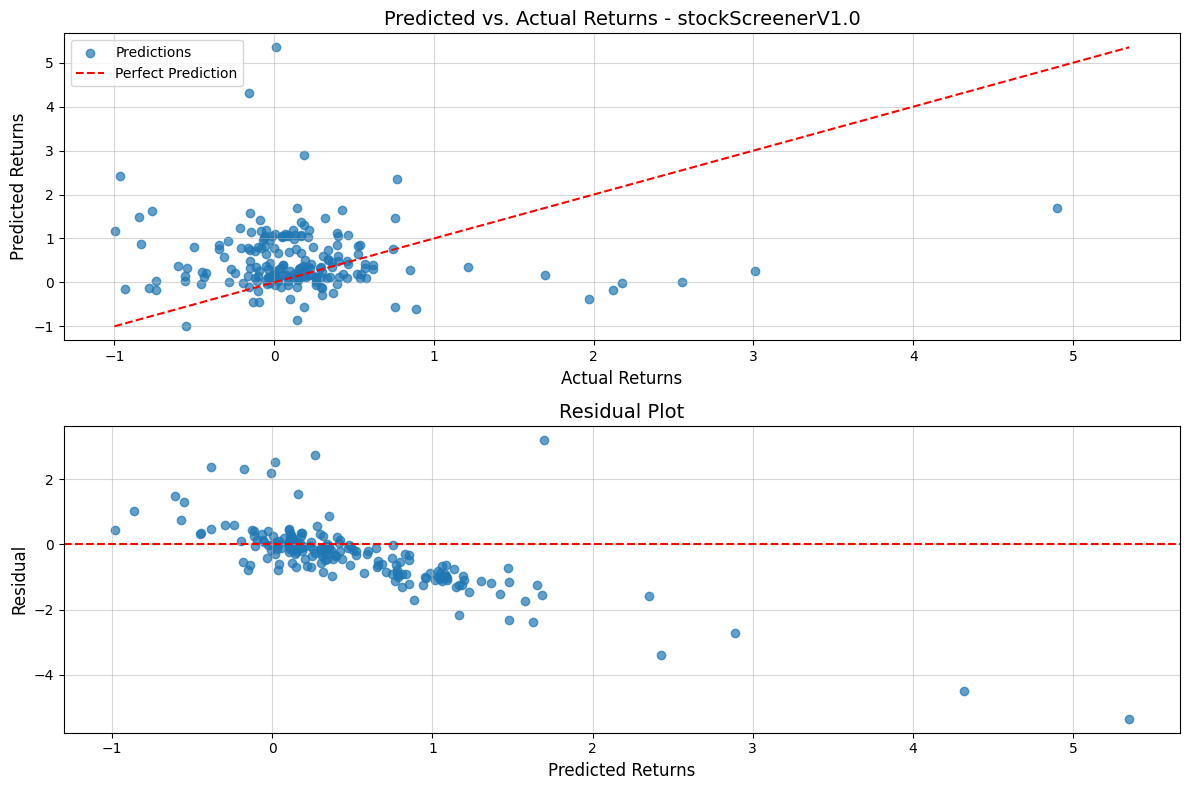

Evaluation Results:
MAE: 0.675
RMSE: 1.020
R2: -1.767


In [422]:
if trainNewModel == True:
    # Evaluate model
    nonTrainingTickers = list(set(symbols) - set(trainingTickers))
    
    if not nonTrainingTickers:
        raise ValueError("No tickers available for testing. Ensure nonTrainingTickers is populated correctly.")
    
    if testSize == 'ALL':
        testTickers = nonTrainingTickers
    else:
        testTickers = np.random.choice(nonTrainingTickers, size=min(testSize, len(nonTrainingTickers)), replace=False).tolist()
    
    print(f"Amount of test tickers: {len(testTickers)}, Expected: {testSize}")
    print(testTickers)
    
    mae, rmse, r2 = evaluate_model(
        learn=learn,  # Your fastai learner
        testTickers=testTickers,
        model_name=modelName,
        model_folder=modelFolder,
        cont_names=contNames,
        cat_names=catNames
    )
    
    if mae is not None and rmse is not None and r2 is not None:
        print(f"Evaluation Results:")
        print(f"MAE: {mae:.3f}")
        print(f"RMSE: {rmse:.3f}")
        print(f"R2: {r2:.3f}")
    else:
        print("Evaluation failed. Metrics are None.")

## Tests

In [423]:
print('Model files in modelFolder:')
for file in modelFolder.glob('*.pkl'):
    print(file.name)

Model files in modelFolder:
animalClassifier.pkl
countryGuesser.pkl
leagueChampionClassifier.pkl
politicianClassifier.pkl
stockScreenerV1.0.pkl


In [424]:
evaluations = pd.read_csv(modelFolder / 'modelEvaluations.csv')
bestModel = evaluations.sort_values('MAE', ascending=True).iloc[0]
bestModel.head()

Model Name    stockScreenerV1.0
Timestamp      2025-01-21 16:17
MAE                       0.675
RMSE                       1.02
R2                       -1.767
Name: 0, dtype: object

### Load model

In [363]:
if os.name == 'nt':
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath

importedModel = Path(f"{bestModel['Model Name']}.pkl") # Change this if you want to try other models
learn = load_learner(modelFolder / importedModel)

## Predictions

In [428]:
if predictionTarget != None:
    if predictionTarget == 'ALL':
        adr_df = pd.read_csv(testFolder / 'tickers.csv')
        symbols = adr_df['Ticker'].tolist()
        test_df = [getTickerData(symbol) for symbol in symbols]
        test_df = pd.concat(test_df, ignore_index=True)  # Concatenate list of DataFrames into a single DataFrame
    else:
        test_df = getTickerData(predictionTarget)

    # Ensure test_df is a DataFrame
    if isinstance(test_df, dict):
        test_df = pd.DataFrame([test_df])

    dl = learn.dls.test_dl(test_df)
    test_df.head()

    if predictionTarget == 'ALL':
        prediction = learn.get_preds(dl=dl)
        adr_df = pd.read_csv(testFolder / 'tickers.csv')
        company_dict = dict(zip(adr_df['Ticker'], adr_df['Company']))
        sorted_predictions = sorted(zip(symbols, prediction[0]), key=lambda x: x[1], reverse=True)
        print(f"Got predictions for {len(sorted_predictions)} tickers, expected: {len(symbols)}")
        print(f"Prediction for best performing tickers:")
        for symbol, pred in sorted_predictions:
            company_name = company_dict.get(symbol, 'Unknown')
            print(f"{symbol} ({company_name}): {pred[0].item() * 100:.2f}%")
    else:
        prediction = learn.get_preds(dl=dl)
        company_name = company_dict.get(predictionTarget, 'Unknown')
        print(f"Prediction for {predictionTarget} ({company_name}):")
        print(f"{prediction[0][0][0].item() * 100:.2f}%")
    print("Free money?!")

predictionTarget = 'ALL' # 'ALL' for all tickers decending, 'None' for no prediction

Error fetching data for A: unsupported operand type(s) for *: 'float' and 'NoneType'


KeyboardInterrupt: 